# 2. Feature Engineering

In this notebook we will transform (scale/normalize,encode categorical features, feature cross), create new features and check feature importance.

At the end of this notebooks we will have the data ready to start training a ML model.

In [1]:
import pandas as pd


## Load dataframe

In [2]:
df = pd.read_feather(path="EDA_dataframe.feather")
print(df.head())

             Datetime  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd  \
0 2010-01-01 00:00:00  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   
1 2010-01-01 01:00:00  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   
2 2010-01-01 02:00:00  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   
3 2010-01-01 03:00:00  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   
4 2010-01-01 04:00:00  2010      1    1     4    NaN   -20 -12.0  1018.0   NW   

     Iws  Is  Ir  
0   1.79   0   0  
1   4.92   0   0  
2   6.71   0   0  
3   9.84   0   0  
4  12.97   0   0  


## Encode Cayegorical Feature - Wind direction

In [7]:
print(df["cbwd"].unique())

['NW' 'cv' 'NE' 'SE']


The variable **cbwd** represents wind direction, and normally is divided into 16 categories:N, NNE, NE, ENE, E, ESE, SE, SSE, S, SSW, SW, WSW, and W.

In our case (in this dataset), the authors thought it was a good idea to group these 16 categories into major 4 categories:
1.NW:
WNW, NW, and NNW. This means, we divide the 360º into 16 slices obtaining the 16 cardinal directions. In order to transform this variable into a numerical variable I decided to divide the full 360º into 16 sections of 22.5º each, and assign each slice to the respective categorie. The end result is the following:

1. **0º     - North (N)**
2. **22.5º  - North-Northeast (NNE)**
3. **45º    - NorthEast (NE)**
4. **67.5º  - East-Northeast (ENE)**
5. **90º    - East (E)**
6. **112.5º - East-Southeast (ESE)**
7. **135º   - Southeast (SE)**
8. **157.5º - South-Shoutheast (SSE)**
9. **180º   - South (S)**
10. **202.5º- South-Southwest (SSW)**
11. **225º  - Southwest(SW)**
12. **247.5º- West-Southwest (WSE)**
13. **270º  - West (W)**
14. **292.5º- West-Northwest (WNW)**
15. **315º  - Northwest (NW)**
16. **337.5º- Nort-Northwest (NNW)**

ValueError: could not convert string to float: 'cv'

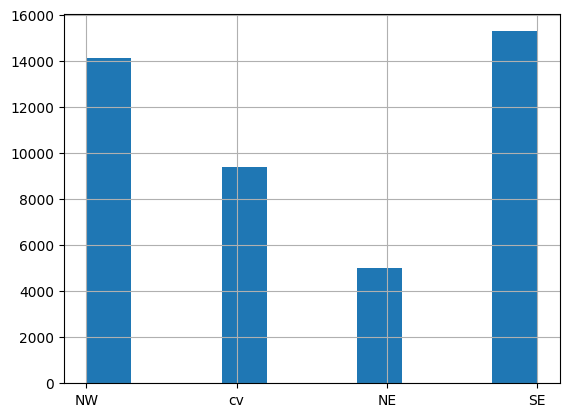

In [6]:
#putting it into code

df["cbwd"].hist()

wind_dict = {"N":0,
             "NNE":22.5,
             "NE":45,
             "ENE":67.5,
             "E":90,
             "ESE":112.5,
             "SE":135,
             "SSE":157.5,
             "S":180,
             "SSW":202.5,
             "SW":225,
             "WSE":247.5,
             "W":270,
             "WNW":292.5,
             "NW":315,
             "NNW":337.5
             }

df["cbwd"] = df["cbwd"].replace(wind_dict).astype(float)
print(df.head())

In [11]:
df["cbwd"].count()

43824